#M3 Project - stockprices predicted with Neural Networks and LSTM.

This assignment tries to predict the future stockprice, of the amazon stock. 
It functions as a base for the project in M4, thus is made rather simple and are expected to be improved in M4.

In this instance, trends from Google have been imported, an used as a weight towards a change in stock prices, from the idea that when a stock rises people will search for it, or perhaps that a stock rises when people search for it (perhaps due to hype)

Link to colab: https://bit.ly/3a7RtHd

#Setup
We use pytrends to download the google trends and yfinance (yahoo finance) to import stock-prices

In [ ]:
!pip install pytrends

In [ ]:
!pip install yfinance

In [ ]:
# Importing the necessary packages
import numpy as np
import pandas as pd
from pandas_datareader import data as web
from yfinance import Ticker
import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pytrends import dailydata
from sklearn.svm import SVR
from keras.preprocessing.sequence import TimeseriesGenerator
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#Preproccesing the data
We have chosen to use the Amazon Stock. There is basically no reason behind it, beside we wanted it to be a stock from one of the bigger companies in the world. We therefore use the widely famed 5-3-1 method, where from a list of 5 stocks, one chose 3 stocks while the other chose 1 out of the 3 remaining, thus we ended with Amazon.

We have defined the starting-date to be today 5 years ago, for easily setting the date 5 years ago. For M4 we might look into using the current year and previous 4 or 5 years, as this corrects for potential seasonal swings in the stock price, such as right before or after reports being published.

In [ ]:
stock = 'AMZN'
start_date = (datetime.datetime.now() - datetime.timedelta(days=1825)).strftime("%Y-%m-%d")
today = datetime.datetime.now().strftime("%Y-%m-%d")

In [ ]:
#This code imports the stock-data
df = yf.download(stock, start=start_date, end=today, progress=False, interval='1d')

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-11,651.229980,657.880005,639.619995,640.150024,640.150024,5474400
2015-12-14,641.750000,658.590027,635.270020,657.909973,657.909973,4329700
2015-12-15,665.030029,671.500000,657.349976,658.640015,658.640015,4753400
2015-12-16,663.559998,677.349976,659.320007,675.770020,675.770020,3964500
2015-12-17,680.000000,682.500000,670.650024,670.650024,670.650024,3681600


In [ ]:
df.columns = [w.lower() for w in df.columns]
df.drop(['adj close'],axis=1,inplace=True)
df['close_y'] = df['close'].shift(-1, fill_value=df['close'].iloc[-1])
df['movement'] = df.close - df.open

The stock-data itself doesn't really hold some information of value. Since we want to predict the closing stock price for the following day, we just shift the closing price one day to get our y value.

Fortunately the yfinance package has build-in the ticker-function, which can import certain information such as `info` which prints out a JSON containing a lot of interesting information, such as the company’s full name, business summary, the industry in which it operates, on which exchange it is listed (also the country, time zone) and many more information

It could also be some of the big trading-houses recommendations, or the same institutional holders, which both are shown below.

In [ ]:
ticker = yf.Ticker(stock)

In [ ]:
recom = ticker.recommendations
recom

,Firm,To Grade,From Grade,Action
Date,,,,
2011-12-29 12:47:00,PiperJaffray,,,main
2012-02-15 07:33:00,PiperJaffray,Overweight,,main
2012-02-16 06:17:00,Morgan Stanley,Equal-Weight,,down
2012-04-02 06:06:00,Bank oferica,Neutral,,down
2012-04-27 06:21:00,Bank oferica,Buy,,up
...,...,...,...,...
2020-10-30 12:31:05,Credit Suisse,Outperform,,main
2020-10-30 16:53:12,Piper Sandler,Overweight,,main
2020-10-30 17:12:40,Benchmark,Buy,,main


In [ ]:
ih = ticker.institutional_holders 
ih

,Holder,Shares,Date Reported,% Out,Value
0,"Vanguard Group, Inc. (The)",32783886,2020-09-29,0.0653,103227605364
1,Blackrock Inc.,27661214,2020-09-29,0.0551,87097694358
2,State Street Corporation,16344982,2020-09-29,0.0326,51465935172
3,"FMR, LLC",15880342,2020-09-29,0.0316,50002909265
4,Price (T.Rowe) Associates Inc,15700902,2020-09-29,0.0313,49437901154
5,"Geode Capital Management, LLC",6398830,2020-09-29,0.0128,20148187985
6,Northern Trust Corporation,5016332,2020-09-29,0.0100,15795075058
7,Morgan Stanley,4875392,2020-09-29,0.0097,15351293052
8,Norges Bank Investment Management,4367787,2019-12-30,0.0087,8070971530
9,Bank Of New York Mellon Corporation,4287954,2020-09-29,0.0085,13501609398


We could use these data in a vary of combinations, which in the end would provide us with more information about the stock itself. We see Morgan Stanley on both tables, which could be combined to see if their recommendations hold value against their position. 

In [ ]:
recom[recom.Firm == 'Morgan Stanley']

,Firm,To Grade,From Grade,Action
Date,,,,
2012-02-16 06:17:00,Morgan Stanley,Equal-Weight,,down
2013-01-07 06:32:45,Morgan Stanley,Overweight,Equal-Weight,up
2014-01-06 06:47:14,Morgan Stanley,Overweight,,main
2014-10-29 07:55:37,Morgan Stanley,Overweight,,init
2015-07-24 03:58:28,Morgan Stanley,Overweight,,main
2016-10-05 14:51:14,Morgan Stanley,Overweight,,main
2017-07-20 19:08:50,Morgan Stanley,Overweight,,main
2018-01-26 19:43:29,Morgan Stanley,Overweight,Overweight,main
2018-02-02 14:11:04,Morgan Stanley,Overweight,Overweight,main


So you can see that Morgan Stanley thinks their portfolio of Amazon is overweight, or that the stock is trading for less than what they value it at. Judged by their position, one could suggest the latter definition of overweight being what Morgan Stanley uses.

#Google Trends

In this section, we import the data used from Google Trends. 
The `get_daily_data` uses the keyword first, then the start and stop, year and month. This part should've been relative dates, but that has caused too much of a problem compared to its necesity for it to be build right now.

In this case, we could've used the stock ticker AMZN as the search keyword, rather than amazon, but we figured we would hit a wider audience using amazon. Both have their pros and cons of course, but we suspect that some people also will be searching for amazon stock or something similar, thus making amazon the keyword a much wider searchterm.

In [ ]:
amazon_data = dailydata.get_daily_data("amazon", start_year=2015, start_mon=1, stop_year=2020, stop_mon=12)

In [ ]:
data = amazon_data.copy()

In [ ]:
data.head()

,amazon_unscaled,amazon_monthly,isPartial,scale,amazon
date,,,,,
2015-01-01,91,56.0,False,0.56,50.96
2015-01-02,99,56.0,NaN,0.56,55.44
2015-01-03,99,56.0,NaN,0.56,55.44
2015-01-04,100,56.0,NaN,0.56,56.00
2015-01-05,90,56.0,NaN,0.56,50.40


The data here is an indexed number, meaning that the date (or dates in this instance) where the term has been searched for the most times has an index of 100 and the least of 0. Absolute numbers are only available if we purchase them from Google, which we are not interested in.

We merge this data with the stock-data from earlier

In [ ]:
data.drop(['isPartial','scale','amazon_monthly','amazon_unscaled'], axis=1, inplace=True)

In [ ]:
merged = pd.merge(df, data, left_index=True, right_index=True)

In [ ]:
merged.head()

,open,high,low,close,volume,close_y,movement,amazon_unscaled,amazon_monthly,amazon
2015-12-11,651.229980,657.880005,639.619995,640.150024,5474400,657.909973,-11.079956,81,85.0,68.85
2015-12-14,641.750000,658.590027,635.270020,657.909973,4329700,658.640015,16.159973,89,85.0,75.65
2015-12-15,665.030029,671.500000,657.349976,658.640015,4753400,675.770020,-6.390015,85,85.0,72.25
2015-12-16,663.559998,677.349976,659.320007,675.770020,3964500,670.650024,12.210022,85,85.0,72.25
2015-12-17,680.000000,682.500000,670.650024,670.650024,3681600,664.140015,-9.349976,84,85.0,71.40


As a final precausion, we want to compare the stock-price to the trends. Therefore we subset it into only those two columns, then scale it to easily compare them using the minmaxscaler, then turning it into a dataframe and plotting it.

In [ ]:
plotting = merged.loc[:,['close_y','amazon']]

In [ ]:
plotscaling = MinMaxScaler(feature_range=(-1, 1))

In [ ]:
plotting = plotscaling.fit_transform(plotting)

In [ ]:
plotting = pd.DataFrame(plotting)

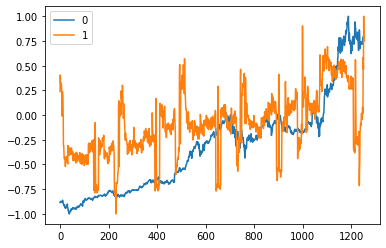

In [ ]:
plotting.plot()

This basically shows us that there is close to none correlation between the search keyword amazon and their stock-price. 

#Testing with supervised machine learning

So to be able to press our neural network further, we want to test how a basic supervised machine learning model works. This also "shows" us that if the SML model is decent, there may not be a need to build a neural network.

Since we are working with sequential data, we dont use train_test_split. Insted we pick the first 80% of obersavations as training set, and the remaning as testing set.

In [ ]:
test_size = int(len(merged) * 0.1)
sml_train = merged.iloc[:-test_size,:].copy() 
sml_test = merged.iloc[-test_size:,:].copy()

We split the dataset into x values and y values. We also specify .values, since the date is not relevant for the training and doesn't work with some of the later preprocessing

In [ ]:
sml_X_train = sml_train.drop(['close_y'],axis=1).values
sml_y_train = sml_train.close_y.values

sml_X_test = sml_test.drop(['close_y'],axis=1).values
sml_y_test = sml_test.close_y.values

In [ ]:
sml_x_scaler = MinMaxScaler(feature_range=(-1, 1))
sml_y_scaler = MinMaxScaler(feature_range=(-1, 1))

We scale all our values to be between -1 and 1. This should help the accuracy of the model.

In [ ]:
sml_X_train = sml_x_scaler.fit_transform(sml_X_train)
sml_y_train = sml_y_scaler.fit_transform(sml_y_train.reshape(-1,1))


sml_X_test = sml_x_scaler.transform(sml_X_test)
sml_y_test = sml_y_scaler.transform(sml_y_test.reshape(-1,1))


Since we are trying to predict a stocks price, we cannot use the linear regression, as we from heart know that a stock will not develop linear, we need to use a model that can take into account that the value can also drop. Because the output of the model is a real number, it becomes very difficult to predict the information at hand, because it has infinite possibilities. However, the main idea is always the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated.

In [ ]:
model = SVR()
model.fit(sml_X_train, sml_y_train)

In [ ]:
model.score(sml_X_test,sml_y_test)

-35.928706963461885

From the documentation of SVR:

*`Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.`*

So basically the model is doing far worse than just regular regression. This can make sense - as the amazon stock in general has risen, it is not entirely wrongful that the model is worse than regular linear regression, but should a downfall eventually come, this model most likely would perform better anyways.

#Preproccessing for Neural Networks

In this module we will take somewhat of the similar steps as in the preproccesing for the machine learning, as most of the same steps are done. The explanation for each step is therefore left out.

In [ ]:
train = df.iloc[:-test_size,:].copy() 
test = df.iloc[-test_size:,:].copy()

In [ ]:
X_train = train.drop(['close_y'],axis=1).values
y_train = train.close_y.values

X_test = test.drop(['close_y'],axis=1).values
y_test = test.close_y.values

In [ ]:
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

In [ ]:
X_train = x_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))


X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test.reshape(-1,1))


#Building and training the neural network model

n_input = how many days we look in the past to predict the next sample. We chose 20 mostly by trial and error.

We set epochs to 100. It's our experience that the more you train the model, the more it will try to predict the daily volatility. If we only trained it for eg. 10 epochs, the model would make a soft curve which didn't look like a real stock development. By trail and error we found 100 to be the best training amount.

In [ ]:
n_input = 20
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 30 # Number of timeseries samples in each batch
epochs = 100
generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)

In [ ]:
print(generator[0][0].shape)

(30, 20, 6)


In [ ]:
test_generator = TimeseriesGenerator(X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(30, 20, 6)


Since we are working with sequential stock data we chose an LSTM model, which is a RNN model.
Activation function is set to relu, and optimizer is adam, since these are the standard for this kind of task.
We chose 2 layers with 50 units each, and once again done by trial and error.

Since we want to predict the actual stock price we use mse(mean squared error) as our loss fuction.

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 50)            11400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 31,651
Trainable params: 31,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=epochs,verbose=0,validation_data=test_generator)

This looks like overfitting, but it works the best in our case.

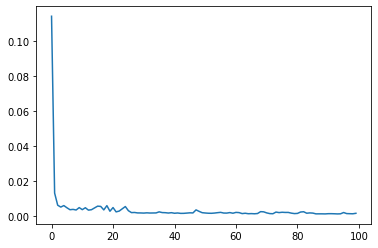

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [ ]:
pd.DataFrame(X_test)

,0,1,2,3,4,5
0,0.959584,0.909487,0.885785,0.905393,-0.419997,-0.480539
1,0.890724,0.875855,0.890106,0.930941,-0.619503,0.337652
2,0.976927,0.908159,0.953296,0.970278,-0.655145,-0.068843
3,1.002307,0.939565,1.005167,0.994024,-0.736057,-0.083164
4,1.001855,0.943729,1.009153,1.006031,-0.795138,0.024760
...,...,...,...,...,...,...
120,1.532213,1.457321,1.508303,1.513610,-0.713333,-0.175966
121,1.517270,1.454306,1.515783,1.498093,-0.743594,-0.180847
122,1.510579,1.427000,1.494829,1.475787,-0.740839,-0.316052
123,1.472065,1.411342,1.478966,1.471557,-0.761536,-0.018841


#Results of the Neural Network

We do some data processing to get it back to the orginal format, so we can compare the real data to the predictions.

In [ ]:
y_pred_scaled = model.predict(test_generator)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({'y_true':y_test.flatten()[n_input:],'y_pred':y_pred.flatten()})
print(results)

          y_true       y_pred
0    3084.000000  2997.022461
1    3008.870117  3021.085693
2    2999.899902  3170.117432
3    2961.969971  3166.101807
4    3196.840088  3165.543213
..           ...          ...
100  3186.729980  3146.289062
101  3162.580078  3149.609619
102  3158.000000  3124.087402
103  3177.290039  3157.810059
104  3177.290039  3143.394531

[105 rows x 2 columns]


In [ ]:
model.evaluate(test_generator)

Looks like the predictions follow the real data to some extent. It follows most of the ups and downs, but doesn't predict that well overall. Also, the model is not very consistant - sometimes it's pretty good and other times it's way off. This alone probably removes any kind of usefullnes for actually trading stocks based on this.

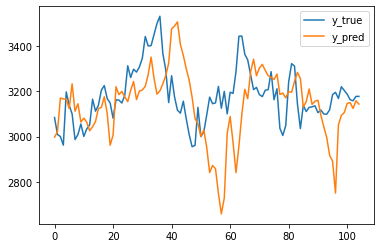

In [ ]:
results.plot()

In [ ]:
results["difference"] = results["y_true"]-results["y_pred"]

In [ ]:
results['change_true'] = results["y_true"] - results['y_true'].shift(+1, fill_value=train['close'].iloc[-1])
results['change_pred'] = results["y_pred"] - results['y_pred'].shift(+1, fill_value=train['close'].iloc[-1])
results["change_dif"] = results["change_true"]-results["change_pred"]

In [ ]:
results

,y_true,y_pred,difference,change_true,change_pred,change_dif
0,3084.000000,2997.022461,86.977539,526.040039,439.062500,86.977539
1,3008.870117,3021.085693,-12.215576,-75.129883,24.063232,-99.193115
2,2999.899902,3170.117432,-170.217529,-8.970215,149.031738,-158.001953
3,2961.969971,3166.101807,-204.131836,-37.929932,-4.015625,-33.914307
4,3196.840088,3165.543213,31.296875,234.870117,-0.558594,235.428711
...,...,...,...,...,...,...
100,3186.729980,3146.289062,40.440918,-16.800049,40.440186,-57.240234
101,3162.580078,3149.609619,12.970459,-24.149902,3.320557,-27.470459
102,3158.000000,3124.087402,33.912598,-4.580078,-25.522217,20.942139
103,3177.290039,3157.810059,19.479980,19.290039,33.722656,-14.432617


this shows the actual daily change and the predicted daily change.
At this it actually does a pretty good job. The changes are not always in the right direction, but they are of a reasonable size.

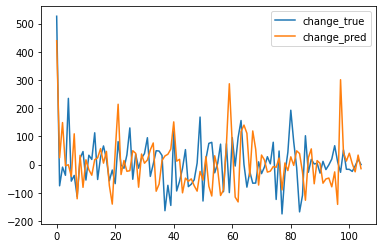

In [ ]:
results.iloc[:,3:5].plot()

#Preproccesing for Neural Networks with Google Trends

Next we want to make a similar model, but we include trends from google trends. Our hypothesis is that stock prices follows the public interest in the company/product. So we download google trends data for the same period as the stock. We only want the collum called "amazon" which is normalized over the period.

In [ ]:
train2 = merged.iloc[:-test_size,:].copy() 
test2 = merged.iloc[-test_size:,:].copy()

In [ ]:
X_train2 = train2.drop(['close_y'],axis=1).values
y_train2 = train2.close_y.values

X_test2 = test2.drop(['close_y'],axis=1).values
y_test2 = test2.close_y.values

In [ ]:
X_train2 = x_scaler.fit_transform(X_train2)
y_train2 = y_scaler.fit_transform(y_train2.reshape(-1,1))

X_test2 = x_scaler.transform(X_test2)
y_test2 = y_scaler.transform(y_test2.reshape(-1,1))

In [ ]:
generator2 = TimeseriesGenerator(X_train2, y_train2, length=n_input, batch_size=b_size)

In [ ]:
n_features2 = X_train2.shape[1] # how many predictors/Xs/features we have to predict y

#Building and training the neural network model with Google Trends

In this part of the assignment, we use the exact same model as we used before. The only difference is that this time, we've included the search-index from Google Trends

In [ ]:
model2 = Sequential()
model2.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(n_input, n_features2)))
model2.add(LSTM(50, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20, 50)            12000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_generator2 = TimeseriesGenerator(X_test2, np.zeros(len(X_test2)), length=n_input, batch_size=b_size)
print(test_generator2[0][0].shape)

(30, 20, 9)


In [ ]:
model2.fit(generator2,epochs=epochs,verbose=1,validation_data=test_generator2)

In [ ]:
model2.evaluate(test_generator2)

In [ ]:
y_pred_scaled2 = model2.predict(test_generator2)
y_pred2 = y_scaler.inverse_transform(y_pred_scaled2)
y_test2 = y_scaler.inverse_transform(y_test2)
results2 = pd.DataFrame({'y_true':y_test2.flatten()[n_input:],'y_pred':y_pred2.flatten()})
print(results2)

          y_true       y_pred
0    3200.000000  3049.302979
1    3104.000000  3155.121094
2    3084.000000  3143.932129
3    3008.870117  2857.845947
4    2999.899902  2986.215576
..           ...          ...
100  3220.080078  2462.485840
101  3203.530029  2646.609863
102  3186.729980  2827.135498
103  3162.580078  2708.228760
104  3158.000000  2582.946045

[105 rows x 2 columns]


#Results of the neural network with Google Trends

These results are not any better tbh. Part of the problem might be that amazon trends during christmas every year, which might confuse the model more than it helps. Also amazon makes money of a lot of different things (eg. AWS), which probalby affects the stock price more than the trend.  

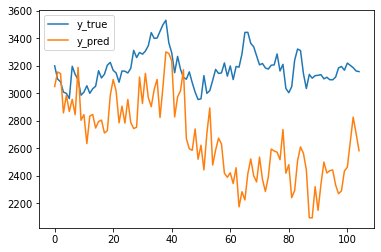

In [ ]:
results2.plot()

In [ ]:
results2['change_true'] = results2["y_true"] - results2['y_true'].shift(+1, fill_value=train['close'].iloc[-1])
results2['change_pred'] = results2["y_pred"] - results2['y_pred'].shift(+1, fill_value=train['close'].iloc[-1])
results2["change_dif"] = results2["change_true"]-results2["change_pred"]

In [ ]:
results2

,y_true,y_pred,change_true,change_pred,change_dif
0,3200.000000,3049.302979,642.040039,491.343018,150.697021
1,3104.000000,3155.121094,-96.000000,105.818115,-201.818115
2,3084.000000,3143.932129,-20.000000,-11.188965,-8.811035
3,3008.870117,2857.845947,-75.129883,-286.086182,210.956299
4,2999.899902,2986.215576,-8.970215,128.369629,-137.339844
...,...,...,...,...,...
100,3220.080078,2462.485840,52.040039,26.990479,25.049561
101,3203.530029,2646.609863,-16.550049,184.124023,-200.674072
102,3186.729980,2827.135498,-16.800049,180.525635,-197.325684
103,3162.580078,2708.228760,-24.149902,-118.906738,94.756836


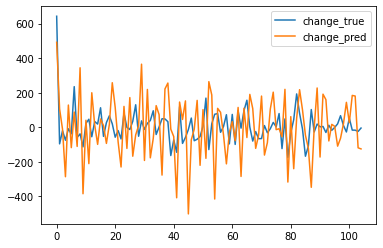

In [ ]:
results2.iloc[:,2:4].plot()

#Conclussion

The only real takeaway from this assignment, is that predicting stock-prices based solely on a stocks price-history, and how often there is searched for the stock, it seems impossible to predict the stocks price correctly. 

For the data to be used in the M4 project, we intend to include various scrabes throughout the internet, such as gdelt, for articles concerning the stock company. We will then be trying to intepret the sentiments from each article, and use that aswell as an indicator for a potential change in stock-price. 

In [ ]:
!jupyter nbconvert --to html "/content/M3_M4_Project.ipynb"

[NbConvertApp] Converting notebook /content/M3_M4_Project.ipynb to html
[NbConvertApp] Writing 576325 bytes to /content/M3_M4_Project.html
